# Notebook de preprocessing
## Mars Express Data Driven Digital Twin

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import models, layers, initializers

In [3]:
FOLDER = "/datasets/train_set/"
FEATURES = ['dmop', 'saaf', 'ftl', 'evtf', 'ltdata']
N_VAL = 500
YEAR = 2012

In [17]:

## import de la première année d'une classe de variables quantitative (saaf, ltdata)
def import_quantitative_df(file_name, folder = FOLDER):
    query = f"{folder}*{file_name}*"
    file_name_list = glob.glob(query) 
    file_name_first = np.sort(file_name_list)[0]
    data = pd.read_csv(file_name_first, sep=",", index_col=0)
    
    print(file_name_first, "imported.")
    data['date'] = data.index
    data = data.reset_index(drop=True) 
    # for file_name in file_name_list_sorted:
    #     print(file_name)
    #     data = pd.read_csv(file_name, sep=",", index_col=0)
    #     saaf_data.append(data)
    # saaf = pd.concat(saaf_data)
    return data.loc[data["date"] < 1230768000000]

def import_power_col(col = "NPWD2451", folder = FOLDER):
    query_power = f"{FOLDER}*power*"
    file_name_list = glob.glob(query_power) 
    file_name = np.sort(file_name_list)[0] # ordonne selon l'année
    data = pd.read_csv(file_name, sep=",", index_col=0, usecols = ["ut_ms", col])
    print(file_name, "imported.")
    data['date'] = data.index
    data = data.reset_index(drop=True)    
    return data.loc[data["date"] < 1230768000000]

def import_ftl():
    file_name = "ftl"
    query = f"{FOLDER}*{file_name}*"
    file_name_list = glob.glob(query) 
    file_name_first = np.sort(file_name_list)[0]
    data = pd.read_csv(file_name_first, sep=",", index_col=0)
    print(file_name_first, "imported.")
    data = pd.get_dummies(data[["type", "flagcomms"]])
    data['date'] = data.index
    data = data.reset_index(drop=True)    
    data["flagcomms"] = data["flagcomms"].astype(int) # Passer les true/false en 1/0
    return data.loc[data["date"] < 1230768000000]


def import_dmop():
    file_name = "dmop"
    query = f"{FOLDER}*{file_name}*"
    file_name_list = glob.glob(query) 
    file_name_first = np.sort(file_name_list)[0]
    data = pd.read_csv(file_name_first, sep=",", index_col=0)
    data['len'] = data.apply(lambda x : len(x['subsystem'].split(".")), axis=1)
    data['commande'] = data.apply(lambda x : x['subsystem'][:4], axis=1)
    print(file_name_first, "imported.")
    data = pd.get_dummies(data[["commande"]])
    data['date'] = data.index
    data = data.reset_index(drop=True)    
    return data.loc[data["date"] < 1230768000000]



# Copie des df puis concatenation 
# on trie par date -> ça intercale les mesures ltdata au milieu de celles de saaf
# on interpole tout ce qui manque (NaN) linéairement avec la méthode interpolate de pandas
# et PAF
def concatenate_and_interpolate_quantitative(df_list):
    
    combined = pd.concat(df_list)
    combined = combined.sort_values("date").reset_index(drop=True)
    combined = combined.interpolate()
    combined["interval"] = pd.Series(combined["date"][1:].to_numpy() - combined["date"][:-1].to_numpy())
    print("Quantitative data interpolated :", len(combined), "rows.")
    return combined

def concatenate_and_interpolate_categorical(df_list):
    
    combined = pd.concat(df_list)
    combined = combined.sort_values("date").reset_index(drop=True)
    # combined = combined["date"].astype('float64')
    # combined = combined.interpolate(method="pad", axis = 1)
    # combined["interval"] = pd.Series(combined["date"][1:].to_numpy() - combined["date"][:-1].to_numpy())
    print("Categorical data interpolated :", len(combined), "rows.")
    return combined



def interpolate(df_list):
    combined = pd.concat(df_list)
    combined = combined.sort_values("date").reset_index(drop=True)
    col = list(combined.columns)
    for c in col:
        if c.split('_')[0] == "type" or c == "flagcomms" or c == "commande" :
            combined[c] = combined[c].interpolate(method="pad")
        else :
            combined[c] = combined[c].interpolate(method="linear")
    combined["interval"] = pd.Series(combined["date"][1:].to_numpy() - combined["date"][:-1].to_numpy())
    print("Data interpolated :", len(combined), "rows.")
    return combined



def create_sampling_rate_vec(sec_interval, df):
    """
    Create a date (ut_ms format) vector piecewiese continuous during "sec_interval" seconds
    """
    timestep = sec_interval * 1000
    median_interval = df["interval"].median()
    nb_samples = len(df) 
    group_size = int(timestep // median_interval)
    nb_group = int(nb_samples // group_size)
    print(f"Sample groups : {nb_group}")
    vec = np.zeros(nb_samples)
    for i in range(nb_group):
        vec[group_size * i: group_size * (i + 1)] = [df["date"][i * group_size]] * group_size

    vec[group_size * nb_group :] = [df["date"][ nb_group * group_size]] * len(vec[group_size * nb_group : ])
    return vec

def subsample_df(df, sampling_rate_sec = 3600):
    """
    Subsample all columns of df with a sampling rate in seconds
    """
    group_vector = create_sampling_rate_vec(sampling_rate_sec, df)
    df["groups"] = group_vector
    df = df.groupby(by="groups").mean() ## place groups en index du df
    df = df.reset_index()
    df.drop(["interval", "groups"], inplace = True, axis = 1)
    print("Data subsampled")
    return df

In [15]:
saaf = import_quantitative_df("saaf")
ltdata = import_quantitative_df("ltdata")
ftl = import_ftl()
dmop = import_dmop()

power = import_power_col()

## categorical

/datasets/train_set/context--2008-08-22_2010-07-10--saaf.csv imported.
/datasets/train_set/context--2008-08-22_2010-07-10--ltdata.csv imported.
/datasets/train_set/context--2008-08-22_2010-07-10--ftl.csv imported.
/datasets/train_set/context--2008-08-22_2010-07-10--dmop.csv imported.
/datasets/train_set/power--2008-08-22_2010-07-10.csv imported.


In [18]:
data = interpolate([saaf, ltdata, ftl, dmop, power])

Data interpolated : 620831 rows.


In [19]:
data = subsample_df(data)

Sample groups : 2942
Data subsampled


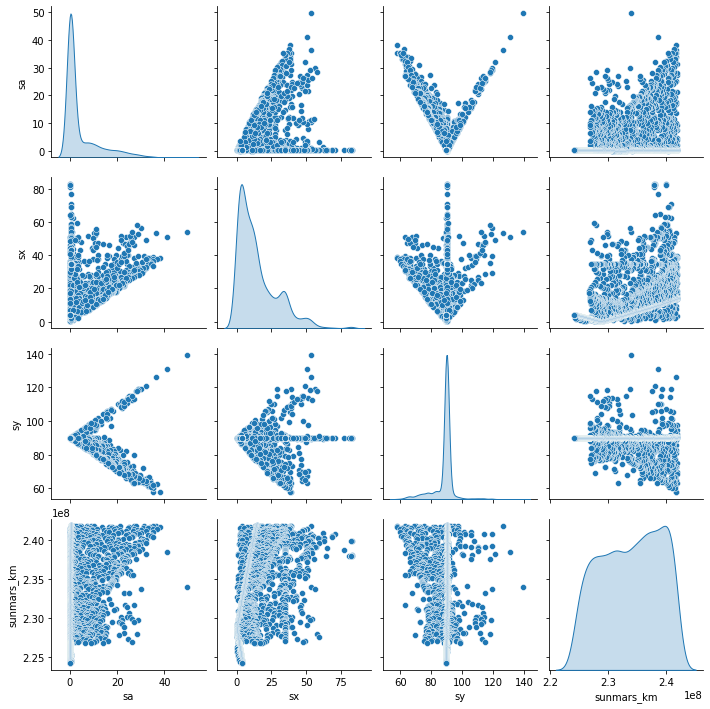

In [38]:
import seaborn as sns
sns.pairplot(X_train[['sa', 'sx', 'sy', 'sunmars_km']], diag_kind='kde')

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

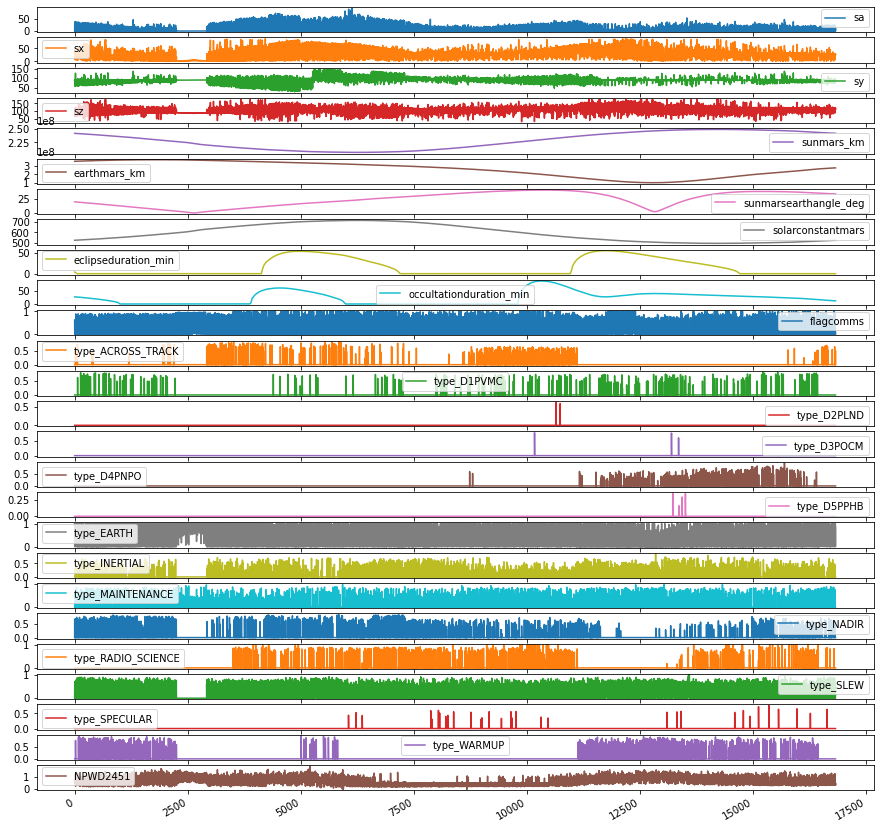

In [ ]:
data.plot(subplots=True, figsize=(15,16))

In [20]:
X = data.copy()
X.drop(["NPWD2451"], inplace = True, axis = 1) # drop
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2943 entries, 0 to 2942
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sa                       2943 non-null   float64
 1   sx                       2943 non-null   float64
 2   sy                       2943 non-null   float64
 3   sz                       2943 non-null   float64
 4   date                     2943 non-null   float64
 5   sunmars_km               2943 non-null   float64
 6   earthmars_km             2943 non-null   float64
 7   sunmarsearthangle_deg    2943 non-null   float64
 8   solarconstantmars        2943 non-null   float64
 9   eclipseduration_min      2943 non-null   float64
 10  occultationduration_min  2943 non-null   float64
 11  flagcomms                2943 non-null   float64
 12  type_ACROSS_TRACK        2943 non-null   float64
 13  type_D1PVMC              2943 non-null   float64
 14  type_D2PLND             

In [37]:
X

,sa,sx,sy,sz,date,sunmars_km,earthmars_km,sunmarsearthangle_deg,solarconstantmars,eclipseduration_min,...,commande_MPER,commande_PDNE,commande_PDNS,commande_PENE,commande_PENS,commande_PPNE,commande_PPNS,commande_SCMN,commande_UPBE,commande_UPBS
0,0.339662,14.550942,90.339662,104.547778,1.219365e+12,2.419361e+08,3.557669e+08,19.561592,522.275935,4.119217,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,4.569218,16.773555,90.605806,94.154005,1.219369e+12,2.419306e+08,3.557889e+08,19.554590,522.299921,4.023866,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,31.255664,39.376540,63.461469,69.698175,1.219371e+12,2.419250e+08,3.558108e+08,19.547589,522.323907,3.928514,...,0.120853,0.0,0.0,0.187204,0.180095,0.0,0.0,0.0,0.0,0.0
3,21.227346,28.788318,75.249526,111.519218,1.219373e+12,2.419195e+08,3.558327e+08,19.540588,522.347893,3.833163,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.339763,14.529289,90.339763,104.524645,1.219377e+12,2.419139e+08,3.558546e+08,19.533586,522.371879,3.737811,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938,28.801445,27.361161,64.267654,87.139147,1.230756e+12,2.183343e+08,3.636341e+08,4.670836,641.294469,0.000000,...,0.002427,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2939,20.543910,41.307251,80.460071,125.045758,1.230758e+12,2.183343e+08,3.636341e+08,4.670836,641.294469,0.000000,...,0.120795,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2940,16.325829,27.279834,105.963768,108.890284,1.230761e+12,2.183343e+08,3.636341e+08,4.670836,641.294469,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2941,0.602109,6.173697,90.312085,95.808839,1.230765e+12,2.183343e+08,3.636341e+08,4.670836,641.294469,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [22]:
y = data.copy()
y.drop(y.loc[:,"sa":"commande_UPBS"], inplace = True, axis = 1)
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2943 entries, 0 to 2942
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   NPWD2451  2943 non-null   float64
dtypes: float64(1)
memory usage: 23.1 KB


In [23]:
def scaling(x_train, x_test):
    scaler = StandardScaler() 
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    return x_train_scaled, x_test_scaled

In [41]:
train_len = int(len(X) * 0.8)
X_train, y_train = X[:train_len], y[:train_len]
X_test, y_test = X[train_len:], y[train_len:]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train_scaled, X_test_scaled = scaling(X_train, X_test)

In [45]:
# def log_mae(y_true, y_pred):
#     y_true_linear = tf.exp(y_true)
#     y_pred_linear = tf.exp(y_pred)
#     return keras.losses.MAE(y_true_linear, y_pred_linear)

# def log_pearsonr(y_true, y_pred):
#     y_true_linear = tf.exp(y_true)
#     y_pred_linear = tf.exp(y_pred)
#     return tfp.stats.correlation(y_true_linear, y_pred_linear)

# def pearsonr(y_true, y_pred):
#     return tfp.stats.correlation(y_true, y_pred)

# def realative_error(y_true, y_pred):
#     return (tf.abs(y_true - y_pred))/y_true

def build_model(n_layers, width):
    """
    Return a compiled keras ANN with n_layers layers and width neurons by layer
    """
    model = models.Sequential()
    # hidden layers
    for i in range(n_layers):
        model.add(layers.Dense(width))

#     output laye/rs
    model.add(layers.Dense(1, activation = "linear"))
    # Optimisation parameters
    metrics = ["mae"]
    model.compile(optimizer = 'adam', loss='mse', metrics = metrics)
    return model

def train_model(x_train_scaled, y_train, model) :
    """
    Run the training procedure and return the trained model, 
    """

    history = model.fit(x_train_scaled, 
                        y_train, 
                        epochs = 100,
                        validation_split=0.2, 
                        verbose = 2)
    return history, model

In [54]:
n_layers = 32
width = 32

    
model = build_model(n_layers, width)

history, trained_model = train_model(X_train_scaled, y_train["NPWD2451"].to_numpy(), model)


Epoch 1/100
59/59 - 0s - loss: 0.1581 - mae: 0.2838 - val_loss: 0.0755 - val_mae: 0.2247
Epoch 2/100
59/59 - 0s - loss: 0.0699 - mae: 0.2189 - val_loss: 0.1023 - val_mae: 0.2551
Epoch 3/100
59/59 - 0s - loss: 0.0674 - mae: 0.2159 - val_loss: 0.0909 - val_mae: 0.2408
Epoch 4/100
59/59 - 0s - loss: 0.0663 - mae: 0.2124 - val_loss: 0.0796 - val_mae: 0.2286
Epoch 5/100
59/59 - 0s - loss: 0.0651 - mae: 0.2106 - val_loss: 0.0844 - val_mae: 0.2349
Epoch 6/100
59/59 - 0s - loss: 0.0650 - mae: 0.2114 - val_loss: 0.0819 - val_mae: 0.2330
Epoch 7/100
59/59 - 0s - loss: 0.0648 - mae: 0.2096 - val_loss: 0.0727 - val_mae: 0.2233
Epoch 8/100
59/59 - 0s - loss: 0.0643 - mae: 0.2085 - val_loss: 0.0862 - val_mae: 0.2372
Epoch 9/100
59/59 - 0s - loss: 0.0639 - mae: 0.2079 - val_loss: 0.0873 - val_mae: 0.2402
Epoch 10/100
59/59 - 0s - loss: 0.0634 - mae: 0.2075 - val_loss: 0.0729 - val_mae: 0.2260
Epoch 11/100
59/59 - 0s - loss: 0.0650 - mae: 0.2095 - val_loss: 0.0980 - val_mae: 0.2511
Epoch 12/100
59/59 

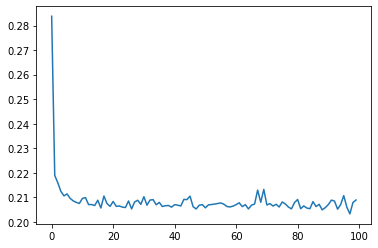

In [55]:

plt.plot(history.history['mae'])

In [56]:
pred = trained_model.predict(X_test_scaled)

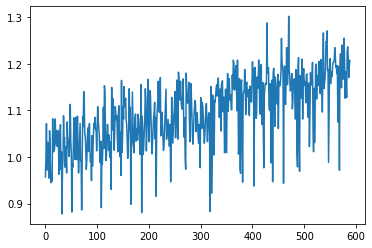

In [57]:
plt.plot(pred)

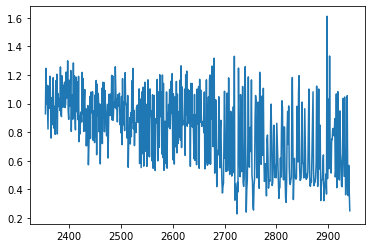

In [58]:
plt.plot(y_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

regr = RandomForestRegressor(20,max_depth=2, random_state=0)
regr.fit(X_train_scaled, y_train.values.ravel())

In [25]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [26]:
reg.score(X_test,y_test)

-29556.104430070798

/opt/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='NPWD2451'>

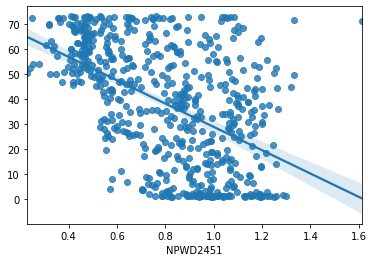

In [27]:
import seaborn as sns
predict = reg.predict(X_test)

sns.regplot(y_test[:1000],predict[:1000])

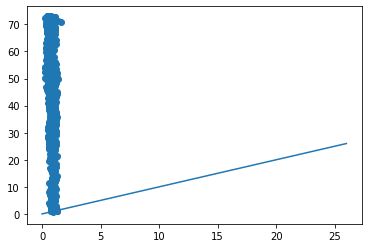

In [28]:
x = np.arange(np.max(predict[:200]))
plt.scatter(y_test[:1000],predict[:1000])
plt.plot(x)


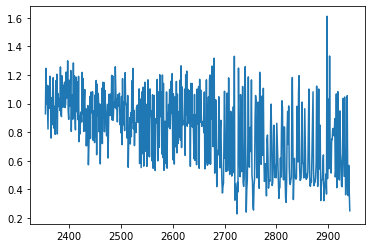

In [33]:
plt.plot(y_test)


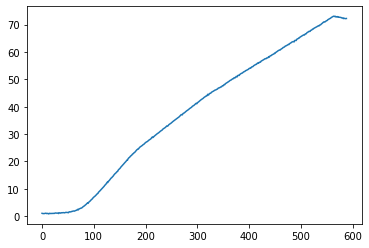

In [35]:
plt.plot(predict)

In [53]:
from metrics import rmse
print("RMSE = ", rmse(pred, y_test))

RMSE =  NPWD2451    0.775403
dtype: float64
